## Task: Train an EMNIST classifier

EMNIST (or extended MNIST) is just like MNIST, a bunch of handwritten images, except instead of just digits (0-9) it also has uppercase and lowercase characters.

You are provided with the code to load the EMNIST train and split **datasets**

Write and train a classifier for EMNIST. Make sure to

- Show how your loss(es) dropped during training.
- Show final performance of your model on untrained data.
- Maintain good code quality.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision.datasets import EMNIST
import torchvision.transforms.functional as F
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

In [ ]:
train_data = EMNIST(root='emnist_data/', split='byclass', download=True)
test_data = EMNIST(root='emnist_data/', split='byclass', download=True, train=False)

Number of classes in dataset: 62
Unique labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
7


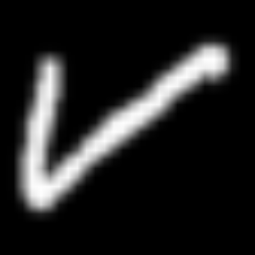

In [ ]:
# This cell is for demo purposes. feel free to remove it if you want.
print('Number of classes in dataset:', len(train_data.classes))
print('Unique labels:', train_data.classes)

demo_img, demo_label = train_data[10]

print(demo_label)
torchvision.transforms.functional.resize(demo_img, (255, 255))

In [ ]:
# Transformations for the EMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the datasets
train_data = EMNIST(root='emnist_data/', split='byclass', train=True, download=True, transform=transform)
test_data = EMNIST(root='emnist_data/', split='byclass', train=False, download=True, transform=transform)

# Define the size of the subset as a fraction of the original dataset
subset_fraction = 0.3 ## You can play with this to get a bigger or smaller subset

# Create indices for the training subset
train_indices = np.random.choice(len(train_data), int(len(train_data) * subset_fraction), replace=False)

# Create the training subset
train_subset = Subset(train_data, train_indices)

# For the test set, you can do the same or use the full test set
test_indices = np.random.choice(len(test_data), int(len(test_data) * subset_fraction), replace=False)
test_subset = Subset(test_data, test_indices)

# Check the size of the subset
print(f"Training subset size: {len(train_subset)}")
print(f"Test subset size: {len(test_subset)}")

# Define the DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

Training subset size: 209379
Test subset size: 34896


In [ ]:
print(train_data[0][0].shape)

torch.Size([1, 28, 28])


In [ ]:
# 4 Layer NN model using LeakyReLU as the activation function
class NN(nn.Module):
    def __init__(self, ni, no, dropout_rate=0.2):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(ni, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, no)

        self.hidden_activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate) # Dropout to reduce overfitting
    def forward(self, x):
        x = self.layer1(x)
        x = self.hidden_activation(x)
        x = self.dropout(x)

        x = self.layer2(x)
        x = self.hidden_activation(x)
        x = self.dropout(x)

        x = self.layer3(x)
        x = self.hidden_activation(x)

        x = self.layer4(x)
        return x

In [ ]:
lr = 1e-4 # Learning Rate
num_epochs = 25
weight_decay = 1e-4 # L2 Regularization Term
device = 'cuda' if torch.cuda.is_available() else 'cpu'
LENGTH = 28 # Length of a picture (28 x 28)
num_classes = 62 # number of classes to predict

model = NN(LENGTH * LENGTH, num_classes)

train_losses = []
test_losses = []

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

model.to(device)
print('Device:', device)

Device: cuda


Pre Training Performance

In [ ]:
with torch.no_grad():
    model.eval()
    correctly_labelled = 0
    batch_losses = 0
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.view(-1, LENGTH*LENGTH).to(device)
        batch_y = batch_y.to(device)

        y_probs = model(batch_x)

        loss = criterion(y_probs, batch_y)
        batch_losses += len(batch_y) * loss.item()

        y_pred = y_probs.argmax(dim=1)
        correctly_labelled += (y_pred == batch_y).sum().item()
    epoch_loss = batch_losses/len(test_loader.dataset)
    test_losses.append(epoch_loss)
    print(f'Val_loss={epoch_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')

Val_loss=4.126519086217727. labelled 329/34896 correctly (0.9428014672168731% accuracy)


Model Training

In [ ]:
for epoch in range(num_epochs):
    model.train()

    epoch_train_loss = 0

    for batch_x, batch_y in train_loader:
        # Send to the GPU
        batch_x = batch_x.view(-1, LENGTH*LENGTH).to(device) # Resize
        batch_y = batch_y.to(device)

        # Predict the porbabilities
        y_probs = model(batch_x)

        # Calculate the loss
        loss = criterion(y_probs, batch_y)

        # Train the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate average loss
        epoch_train_loss += len(batch_y) * loss.item()
    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss) # Track loss

    with torch.no_grad():
        model.eval()
        correctly_labelled = 0
        batch_losses = 0
        for batch_x, batch_y in test_loader:
            # Send to the GPU
            batch_x = batch_x.view(-1, LENGTH*LENGTH).to(device) # Resize
            batch_y = batch_y.to(device)

            # Predict probabilities
            y_probs = model(batch_x)

            # Calculate Loss
            loss = criterion(y_probs, batch_y)
            batch_losses += len(batch_y) * loss.item()

            # Calculate correct labels
            y_pred = y_probs.argmax(dim=1)
            correctly_labelled += (y_pred == batch_y).sum().item()

    test_epoch_loss = batch_losses/len(test_loader.dataset)
    test_losses.append(test_epoch_loss) # Track loss
    print(f'Epoch: {epoch}, train_loss={epoch_train_loss}, val_loss={test_epoch_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')

Epoch: 0, train_loss=1.367029711515229, val_loss=0.8611466559943995. labelled 25914/34896 correctly (74.26066024759285% accuracy)
Epoch: 1, train_loss=0.8212880704351899, val_loss=0.6772998584513815. labelled 27439/34896 correctly (78.63078862906924% accuracy)
Epoch: 2, train_loss=0.6961130616413566, val_loss=0.6007617820517178. labelled 28062/34896 correctly (80.41609353507565% accuracy)
Epoch: 3, train_loss=0.63134455296538, val_loss=0.5554273823897043. labelled 28468/34896 correctly (81.57955066483265% accuracy)
Epoch: 4, train_loss=0.5894070734654231, val_loss=0.5274006745537614. labelled 28754/34896 correctly (82.39912883998166% accuracy)
Epoch: 5, train_loss=0.5608922053306562, val_loss=0.5087613004068889. labelled 28855/34896 correctly (82.68856029344337% accuracy)
Epoch: 6, train_loss=0.5367839769510279, val_loss=0.4956988158410758. labelled 28901/34896 correctly (82.82038055937643% accuracy)
Epoch: 7, train_loss=0.5197203205472151, val_loss=0.48013043724741755. labelled 29092/

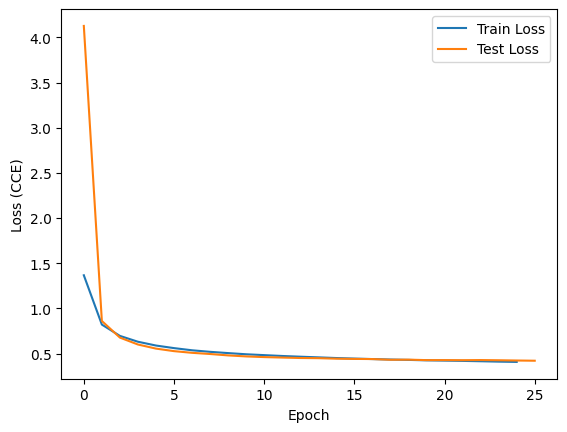

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses  , label='Test Loss')

plt.ylabel('Loss (CCE)')
plt.xlabel('Epoch')

plt.legend()
plt.show()


In [ ]:
print(f'Final Loss:\t\t{test_losses[-1]}')
print(f'Labelled Correctly:\t{correctly_labelled}/{len(test_loader.dataset)}')
print(f'Final Accuracy:\t\t{correctly_labelled/len(test_loader.dataset)*100}%')

Final Loss:		0.42123251110110355
Labelled Correctly:	29652/34896
Final Accuracy:		84.97248968363135%
